In [19]:
import os, numpy as np
import matplotlib.pyplot as plt
from parseDiFX import *

def get_file(path):
    #opens and external file and makes it into a list
    fopen = path
    f=open(fopen, 'r+')
    g=list(f)
    g=map(lambda s: s.strip(), g)
    return np.array(list(g))

def splitt(old_list):
    #splits the list entries into sublists
    new_list=[]
    for i in old_list:
        new_list+=[i.split()]
    return np.array(new_list)

In [20]:
os.system('mv baseline* fringe/)

SyntaxError: EOL while scanning string literal (<ipython-input-20-f49e7df37929>, line 1)

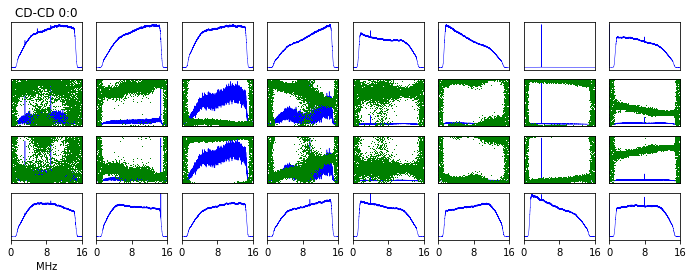

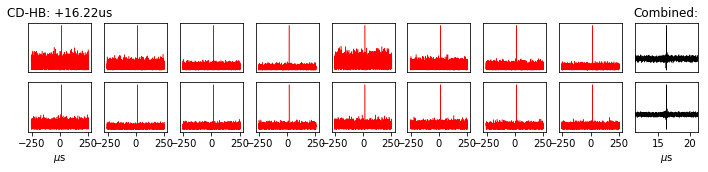

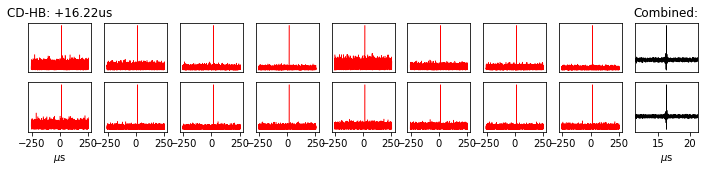

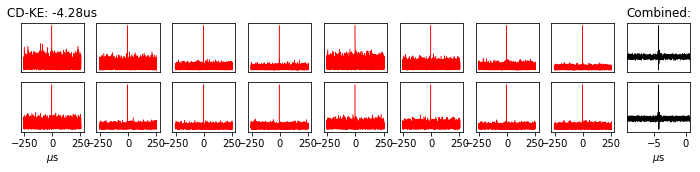

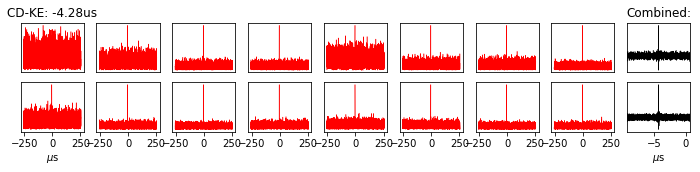

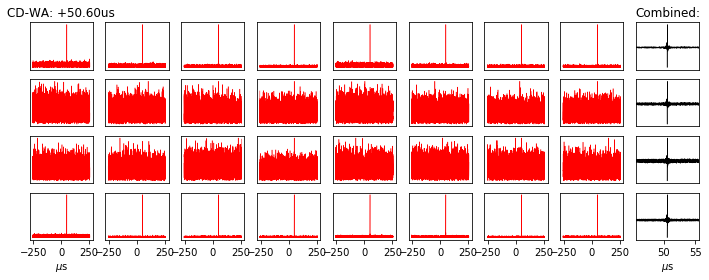

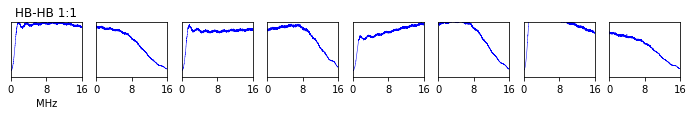

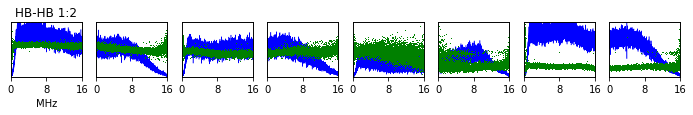

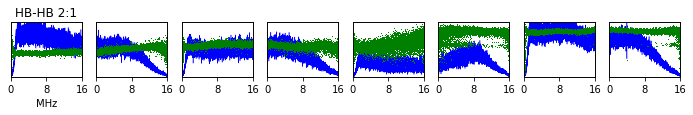

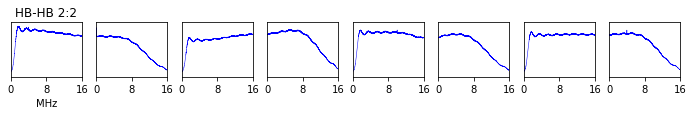

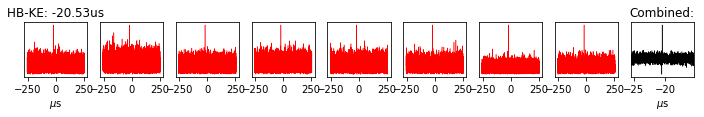

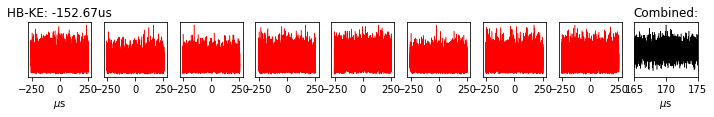

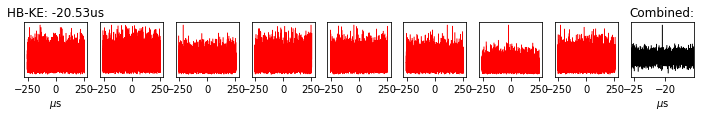

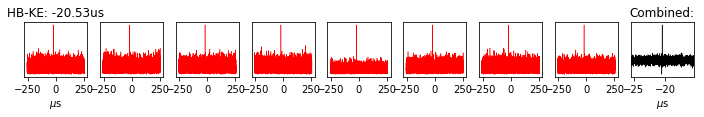

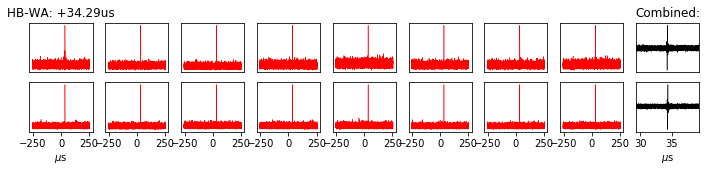

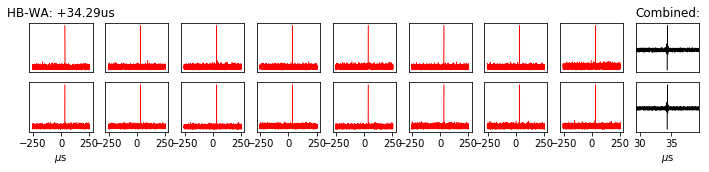

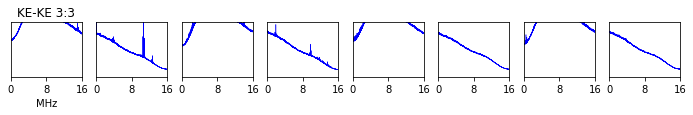

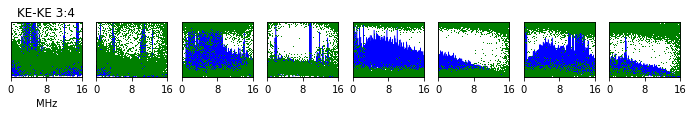

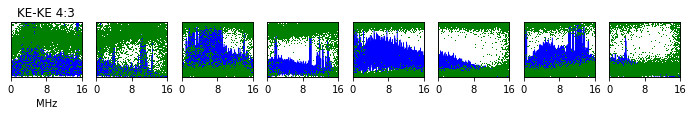

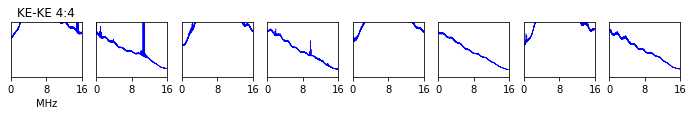

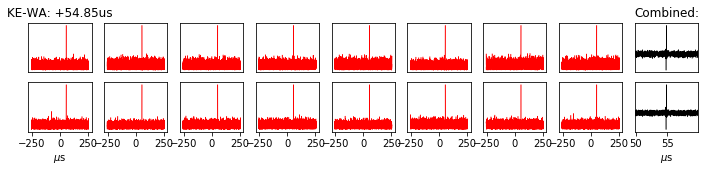

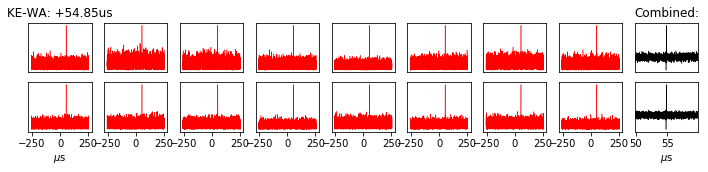

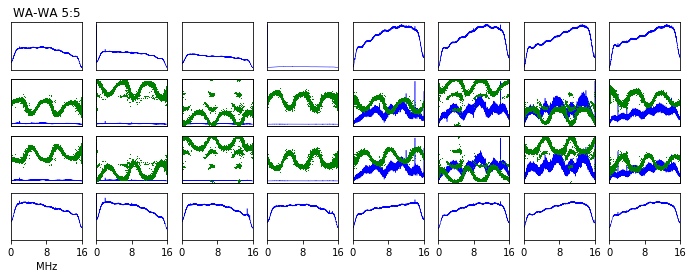

In [374]:
direct    = '/home/observer/correlations2/s015e/'
inputfile = '/home/observer/correlations2/s015e/s015e_1.input'

plot_path = '/home/observer/fringe_plots/'

try: os.remove(plot_path+'baseline_*')
except OSError: pass

(nfqs, fqs) = get_freqtable_info(inputfile)
(ntel, tel) = get_telescopetable_info(inputfile)
(ndts, dts) = get_datastreamtable_info(inputfile)
(nbls, bls) = get_baselinetable_info(inputfile)

infiles = [s for s in os.listdir(direct+'fringe/') if 'baseline_' in s]
for b in range(nbls):
    #check if same datastream
    samedstr = dts[bls[b].dsaindex].telescopeindex==dts[bls[b].dsbindex].telescopeindex
    if samedstr:
        # make autocorrelation figure 
        fig, AX = plt.subplots(np.max(bls[b].freqpols),
                               bls[b].nfreq,figsize=(1.5*bls[b].nfreq,
                                                     np.max(bls[b].freqpols)))
        # catch for misshapen AX array
        if np.max(bls[b].freqpols)==1 or bls[b].nfreq==1:
            AX = AX.reshape(np.max(bls[b].freqpols),bls[b].nfreq)
        bw = fqs[dts[bls[b].dsaindex].recfreqindex[0]].bandwidth
        nchan = fqs[dts[bls[b].dsaindex].recfreqindex[0]].numchan
        speca = fqs[dts[bls[b].dsaindex].recfreqindex[0]].specavg
        dt = speca*bw/(nchan)
        V  = []
        maxlag = 0
        minlag = 0
        delay  = 0
        for f in range(bls[b].nfreq):    #iterating over IFS
            maxamp = 0.1
            for p in range(bls[b].freqpols[f]):  #iterating over products
                key = 'baseline_{}_freq_{}_product_{}_'.format(b,f,p)
                bfp = []  # time averaging
                for infile in infiles:
                    # same baseline, freq and product, different time
                    if infile[:28]==key[:28]:
                        bfp.append(infile)
                data = []
                for g in bfp:
                    data.append(np.array(splitt(get_file(direct+'fringe/'+g))).astype(float))
                d = np.asarray(data)
                d[:,:,2:][d[:,:,2:] ==0] = np.nan
                # averaging over time - may be problematic for large rate
                D = np.nanmean(d,axis=0) 
                
                # making XCORR phases. Order seems consistent (e.g. RR,RL,LR,LL)
                if p==1 or p==2:
                    xa = AX[p,f].twinx()
                    xa.plot(dt*D[:,0],D[:,2],'g,',lw=0.5)
                    xa.set_ylim([-np.pi,np.pi])
                    xa.set_yticks([])
                elif bls[b].dsaindex!=bls[b].dsbindex:
                    xa = AX[p,f].twinx()
                    xa.plot(dt*D[:,0],D[:,2],'g,',lw=0.5)
                    xa.set_ylim([-np.pi,np.pi])
                    xa.set_yticks([])                
                
                # setting max amplitude
                if maxamp<1.25*np.percentile(D[:,1],95):
                    maxamp = 1.25*np.percentile(D[:,1],95)
                AX[p,f].plot(dt*D[:,0],D[:,1],'b-',lw=0.5)
                AX[p,f].set_yticks([])   

                xmax = dt*(D[:,0].shape[0])
                AX[p,f].set_xlim([0,xmax])
                if bls[b].freqpols[f] > 1 and p!=bls[b].freqpols[f]-1:
                    AX[p,f].set_xticks([])
                else:
                    AX[p,f].set_xticks(np.arange(0,xmax+1,xmax/2))
                    AX[p,0].set_xlabel('MHz')

            for f in range(bls[b].nfreq):
                AX[p,f].set_ylim([0,maxamp])


        AX[0,0].set_title('{}-{} {}:{}'.format(tel[dts[bls[b].dsaindex].telescopeindex].name,
                                               tel[dts[bls[b].dsbindex].telescopeindex].name,
                                               bls[b].dsaindex,bls[b].dsbindex))
        #fig.savefig(plot_path+'baseline_{}_{}_{}.png'.format(b,tel[dts[bls[b].dsaindex].telescopeindex].name,
        #tel[dts[bls[b].dsbindex].telescopeindex].name),bbox_inches='tight');
    else:
        # make xcorrelation figure, has extra plot to the side for total fringe
        fig, AX = plt.subplots(np.max(bls[b].freqpols),
                               bls[b].nfreq+1,figsize=(1.5*bls[b].nfreq,
                                                     np.max(bls[b].freqpols)))
        # catch for misshapen AX array
        if np.max(bls[b].freqpols)==1 or bls[b].nfreq==1:
            AX = AX.reshape(np.max(bls[b].freqpols),bls[b].nfreq+1)
        bw = fqs[dts[bls[b].dsaindex].recfreqindex[0]].bandwidth
        nchan = fqs[dts[bls[b].dsaindex].recfreqindex[0]].numchan
        speca = fqs[dts[bls[b].dsaindex].recfreqindex[0]].specavg
        dt = speca*bw/nchan
        V  = []
        maxlag = 0
        minlag = 0
        delay  = 0
        for p in range(bls[b].freqpols[f]): #iterating over products
            for f in range(bls[b].nfreq):   #iterating over IFS
                key = 'baseline_{}_freq_{}_product_{}_'.format(b,f,p)
                bfp = [] # time averaging
                for infile in infiles:
                    # same baseline, freq and product
                    if infile[:28]==key[:28]:
                        bfp.append(infile)
                data = []
                for g in bfp:
                    data.append(np.array(splitt(get_file(direct+'fringe/'+g))).astype(float))

                d = np.asarray(data)
                d[:,:,2:][d[:,:,2:] ==0] = np.nan
                # D = np.nanmean(d,axis=0) this step here is bad
                # need to average lags
                vis = d[:,:,1]*np.exp(np.complex(0,1)*d[:,:,2])
                lag = np.fft.fftshift(np.fft.ifft(vis,axis=-1)) 

                Lag = np.nanmean(abs(lag),axis=0)
                V  += list(np.fft.fftshift(np.fft.fft(Lag)))

                D   = np.zeros(shape=(Lag.shape[0],3))
                D[:,0] = np.arange(0,Lag.shape[0],1)
                #dt  = bw/lag.shape[0] 
                t   = -1/(dt)*(D[:,0]/D[:,0].max()-0.5)
                #AX[p,f].plot(t,lag.real+abs(lag.imag),'r-',lw=0.5)
                AX[p,f].plot(t,Lag,'r-',lw=0.5)
                if abs(Lag).max()>maxlag:
                    maxlag=abs(Lag).max()
                    delay =t[abs(Lag).argmax()]
                #if lag.real.min()<minlag: minlag = lag.real.min()
                AX[p,f].set_yticks([])
                if bls[b].freqpols[f] > 1 and p!=bls[b].freqpols[f]-1:
                    AX[p,f].set_xticks([])
                else:
                    AX[p, 0].set_xlabel(R'$\mu$s')
                    AX[p,-1].set_xlabel(R'$\mu$s')

            # plotting total fringe
            v = np.array(V).flatten()
            L = np.fft.ifft(v)
            T = -1/dt*(np.arange(0,v.shape[0],1)/float(v.shape[0])-0.5)
            AX[p,-1].plot(T,L.real,'k-',lw=0.5);
            AX[p,-1].set_xlim(T[abs(L).argmax()]-5,T[abs(L).argmax()]+5)
            AX[p,-1].set_yticks([]);
            if bls[b].freqpols[f] > 1 and p!=bls[b].freqpols[f]-1:
                AX[p,-1].set_xticks([])
            if p==0:
                AX[p,-1].set_title('Combined:')


        AX[0,0].set_title('{}-{}: {:+4.2f}us'.format(tel[dts[bls[b].dsaindex].telescopeindex].name,
                            tel[dts[bls[b].dsbindex].telescopeindex].name,delay))          

        #fig.savefig(plot_path+'baseline_{}_{}_{}.png'.format(b,tel[dts[bls[b].dsaindex].telescopeindex].name,
        #                    tel[dts[bls[b].dsbindex].telescopeindex].name),bbox_inches='tight');

In [309]:
mjd=[]
for infile in infiles:
    mjd.append(float(infile.split('_')[6])+(float(infile.split('_')[7][0:2])
                         +(float(infile.split('_')[7][2:4])
                         + float(infile.split('_')[7][4:])/60.0)/60.0)/24.0)

In [334]:
mjd0,mjd1=[int(s.split(':')[-1]) for s in get_file(inputfile) if 'START' in s]
time = aTime(mjd0+mjd1/86400.,format='mjd')
os.system('echo {} > {}/TIME'.format(time.yday,plot_path));

In [366]:
with open('/home/observer/fringe_plots/TIME','r') as f:
    fringe_time = datetime.datetime.strptime(f.readlines()[0],'%Y:%j:%H:%M:%S.%f\n').strftime('%H:%M:%S')
    
fringe_time

'23:34:17'

In [362]:
datetime.datetime.strptime(poo[0],'%Y:%j:%H:%M:%S.%f\n'

datetime.datetime(2022, 8, 23, 23, 34, 17)

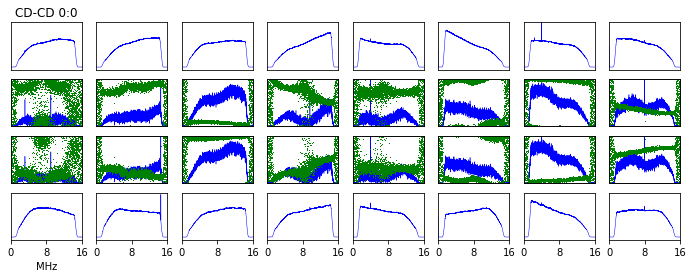

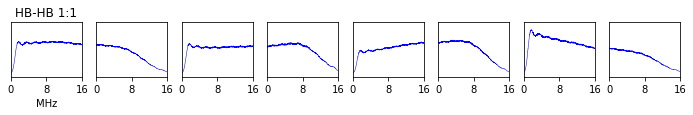

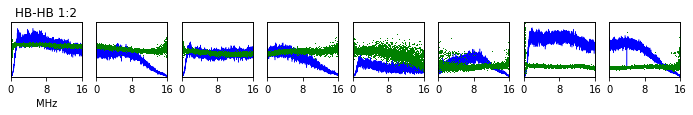

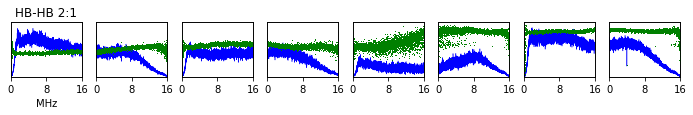

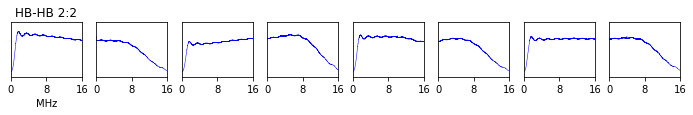

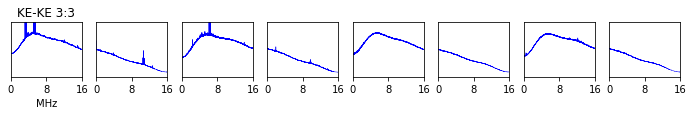

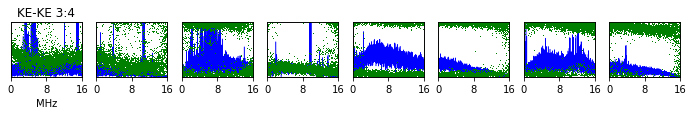

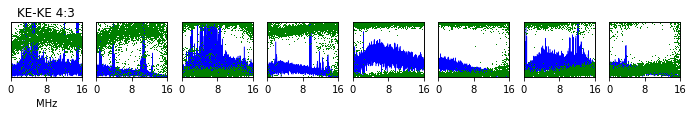

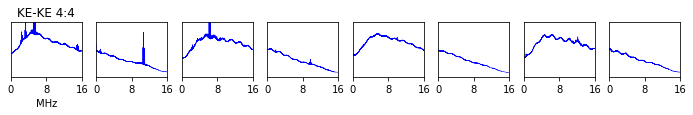

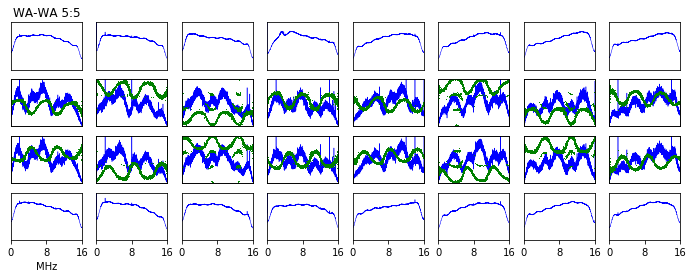

In [22]:
## autocorrs

for b in range(nbls):
    #check if same datastream
    samedstr = dts[bls[b].dsaindex].telescopeindex==dts[bls[b].dsbindex].telescopeindex
    if samedstr:
        # make figure and 
        fig, AX = plt.subplots(np.max(bls[b].freqpols),
                               bls[b].nfreq,figsize=(1.5*bls[b].nfreq,
                                                     np.max(bls[b].freqpols)))
        # catch for misshapen AX array
        if np.max(bls[b].freqpols)==1 or bls[b].nfreq==1:
            AX = AX.reshape(np.max(bls[b].freqpols),bls[b].nfreq)
        bw = fqs[dts[bls[b].dsaindex].recfreqindex[0]].bandwidth
        nchan = fqs[dts[bls[b].dsaindex].recfreqindex[0]].numchan
        speca = fqs[dts[bls[b].dsaindex].recfreqindex[0]].specavg
        dt = speca*bw/(nchan)
        V  = []
        maxlag = 0
        minlag = 0
        delay  = 0
        for p in range(bls[b].freqpols[f]):  #iterating over products
            maxamp = 0.1
            for f in range(bls[b].nfreq):    #iterating over baselines
                key = 'baseline_{}_freq_{}_product_{}_'.format(b,f,p)
                bfp = []  # time averaging
                for infile in infiles:
                    # same baseline, freq and product, different time
                    if infile[:28]==key[:28]:
                        bfp.append(infile)
                data = []
                for g in bfp:
                    data.append(np.array(splitt(get_file(direct+'fringe/'+g))).astype(float))
                d = np.asarray(data)
                d[:,:,2:][d[:,:,2:] ==0] = np.nan
                # averaging over time - may be problematic for large rate
                D = np.nanmean(d,axis=0) 
                
                # making XCORR phases. Order seems consistent (e.g. RR,RL,LR,LL)
                if p==1 or p==2:
                    xa = AX[p,f].twinx()
                    xa.plot(dt*D[:,0],D[:,2],'g,',lw=0.5)
                    xa.set_ylim([-np.pi,np.pi])
                    xa.set_yticks([])
                elif bls[b].dsaindex!=bls[b].dsbindex:
                    xa = AX[p,f].twinx()
                    xa.plot(dt*D[:,0],D[:,2],'g,',lw=0.5)
                    xa.set_ylim([-np.pi,np.pi])
                    xa.set_yticks([])                
                
                # setting max amplitude
                if maxamp<1.25*np.percentile(D[:,1],95):
                    maxamp = 1.25*np.percentile(D[:,1],95)
                AX[p,f].plot(dt*D[:,0],D[:,1],'b-',lw=0.5)
                AX[p,f].set_yticks([])   

                xmax = dt*(D[:,0].shape[0])
                AX[p,f].set_xlim([0,xmax])
                if bls[b].freqpols[f] > 1 and p!=bls[b].freqpols[f]-1:
                    AX[p,f].set_xticks([])
                else:
                    AX[p,f].set_xticks(np.arange(0,xmax+1,xmax/2))
                    AX[p,0].set_xlabel('MHz')

            for f in range(bls[b].nfreq):
                AX[p,f].set_ylim([0,maxamp])


        AX[0,0].set_title('{}-{} {}:{}'.format(tel[dts[bls[b].dsaindex].telescopeindex].name,
                                               tel[dts[bls[b].dsbindex].telescopeindex].name,
                                               bls[b].dsaindex,bls[b].dsbindex))
        #fig.savefig(plot_path+'baseline_{}_{}_{}.png'.format(b,tel[dts[bls[b].dsaindex].telescopeindex].name,
        #tel[dts[bls[b].dsbindex].telescopeindex].name),bbox_inches='tight');

Text(0.5,1,'CD-HB: +16.22us')

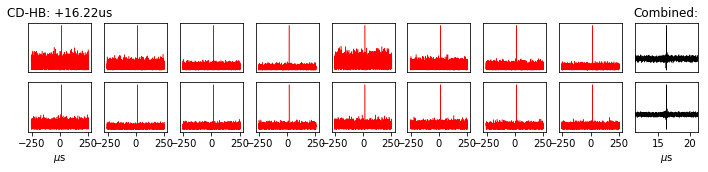

In [373]:
b = 1

fig, AX = plt.subplots(np.max(bls[b].freqpols),
               bls[b].nfreq+1,figsize=(1.5*bls[b].nfreq,
                                     np.max(bls[b].freqpols)))
# catch for misshapen AX array
if np.max(bls[b].freqpols)==1 or bls[b].nfreq==1:
    AX = AX.reshape(np.max(bls[b].freqpols),bls[b].nfreq+1)
bw = fqs[dts[bls[b].dsaindex].recfreqindex[0]].bandwidth
nchan = fqs[dts[bls[b].dsaindex].recfreqindex[0]].numchan
speca = fqs[dts[bls[b].dsaindex].recfreqindex[0]].specavg
dt = speca*bw/nchan
V  = []
maxlag = 0
minlag = 0
delay  = 0
for p in range(bls[b].freqpols[f]): #iterating over products
    for f in range(bls[b].nfreq):   #iterating over IFS
        key = 'baseline_{}_freq_{}_product_{}_'.format(b,f,p)
        bfp = [] # time averaging
        for infile in infiles:
            # same baseline, freq and product
            if infile[:28]==key[:28]:
                bfp.append(infile)
        data = []
        for g in bfp:
            data.append(np.array(splitt(get_file(direct+'fringe/'+g))).astype(float))
        d = np.asarray(data)
        d[:,:,2:][d[:,:,2:] ==0] = np.nan
        # D = np.nanmean(d,axis=0) this step here is bad
        # need to average lags
        vis = d[:,:,1]*np.exp(np.complex(0,1)*d[:,:,2])
        lag = np.fft.fftshift(np.fft.ifft(vis,axis=-1)) 
        
        Lag = np.nanmean(abs(lag),axis=0)
        V  += list(np.fft.fftshift(np.fft.fft(Lag)))
        
        D   = np.zeros(shape=(Lag.shape[0],3))
        D[:,0] = np.arange(0,Lag.shape[0],1)
        #dt  = bw/lag.shape[0] 
        t   = -1/(dt)*(D[:,0]/D[:,0].max()-0.5)
        #AX[p,f].plot(t,lag.real+abs(lag.imag),'r-',lw=0.5)
        AX[p,f].plot(t,Lag,'r-',lw=0.5)
        if abs(Lag).max()>maxlag:
            maxlag=abs(Lag).max()
            delay =t[abs(Lag).argmax()]
        #if lag.real.min()<minlag: minlag = lag.real.min()
        AX[p,f].set_yticks([])
        if bls[b].freqpols[f] > 1 and p!=bls[b].freqpols[f]-1:
            AX[p,f].set_xticks([])
        else:
            AX[p, 0].set_xlabel(R'$\mu$s')
            AX[p,-1].set_xlabel(R'$\mu$s')

    # plotting total fringe
    v = np.array(V).flatten()
    L = np.fft.ifft(v)
    T = -1/dt*(np.arange(0,v.shape[0],1)/float(v.shape[0])-0.5)
    AX[p,-1].plot(T,L.real,'k-',lw=0.5);
    AX[p,-1].set_xlim(T[abs(L).argmax()]-5,T[abs(L).argmax()]+5)
    AX[p,-1].set_yticks([]);
    if bls[b].freqpols[f] > 1 and p!=bls[b].freqpols[f]-1:
        AX[p,-1].set_xticks([])
    if p==0:
        AX[p,-1].set_title('Combined:')


AX[0,0].set_title('{}-{}: {:+4.2f}us'.format(tel[dts[bls[b].dsaindex].telescopeindex].name,
                    tel[dts[bls[b].dsbindex].telescopeindex].name,delay))  

In [372]:
lag

array([[            nan           +nanj,             nan           +nanj,
                    nan           +nanj, ...,
                    nan           +nanj,             nan           +nanj,
                    nan           +nanj],
       [            nan           +nanj,             nan           +nanj,
                    nan           +nanj, ...,
                    nan           +nanj,             nan           +nanj,
                    nan           +nanj],
       [-1.59053092e-04-2.75946133e-05j,  1.01419865e-04+4.66382456e-05j,
         1.92457884e-04+2.49010907e-06j, ...,
        -4.73116111e-05+3.37736701e-05j,  1.67965362e-04+1.94360537e-04j,
        -2.14151335e-04-4.50695745e-05j]])

34.3125
34.375
34.375


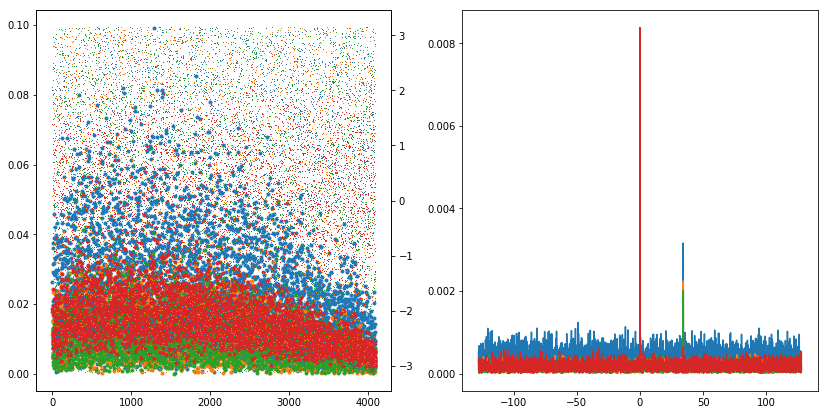

In [90]:
t= 2

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,7))

xa1 = ax1.twinx()

ax1.plot(d[t,:,0],d[t,:,1],'.')
xa1.plot(d[t,:,0],d[t,:,2],',')

vis = d[t,:,1]*np.exp(np.complex(0,1)*d[t,:,2])

l = np.fft.fftshift(np.fft.ifft(vis))
T = -1/dt*(np.arange(0,vis.shape[0],1)/float(vis.shape[0])-0.5)

ax2.plot(T,abs(l))
print(T[abs(l).argmax()]);
    
D = np.nanmean(d,axis=0)
Vis = D[:,1]*np.exp(np.complex(0,1)*D[:,2])
ax1.plot(D[:,0],D[:,1],'.')
xa1.plot(D[:,0],D[:,2],',')
L = np.fft.fftshift(np.fft.ifft(Vis))
ax2.plot(T,abs(L));

In [150]:
vis = d[:,:,1]*np.exp(np.complex(0,1)*d[:,:,2])

vis1= d[1,:,1]*np.exp(np.complex(0,1)*d[1,:,2])

In [210]:
vis = d[:,:,1]*np.exp(np.complex(0,1)*d[:,:,2])
lag = np.fft.fftshift(np.fft.ifft(vis,axis=-1)) 

Lag = np.nanmean(abs(lag),axis=0)

Vis = np.fft.fft(Lag)
D   = np.zeros(shape=(Lag.shape[0],3))
D[:,0] = np.arange(0,Lag.shape[0],1)
D[:,1] = abs(Vis)
D[:,2] = np.arctan(Vis.imag/Vis.real)

array([  0.        ,  18.79974685,  70.31462814, ...,  42.89176946,
       -70.31462814, -18.79974685])

(0, 0.025)

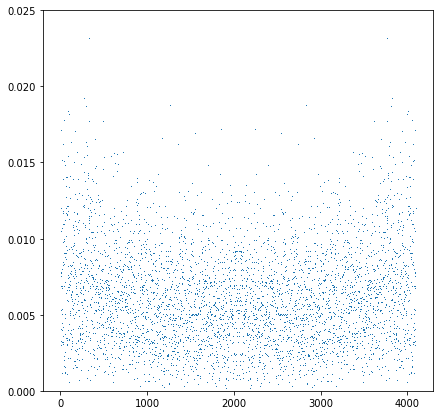

In [218]:
fig, ax = plt.subplots(1,figsize=(7,7))

ax.plot(D[:,0],D[:,1],',')
ax.set_ylim(0,0.025)